### Importing Libraries

In [1]:
# Standard Libraries #
import pandas as pd
import numpy as np
import itertools
import pickle
import io

# ARIMA Functions #
import arima_functions as armf

# Visualisation Libraries #
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries #
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

# Time Series Plots #
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Error Metrics #
from sklearn.metrics import mean_squared_error

# Seaborn Plotting Style #
sns.set(style='ticks', context='poster')

# Misc #
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Loading Our Data

In [2]:
with open('./data_with_feature_engineering.pickle', 'rb') as f:
    df = pickle.load(f)

### Aggregating our data and splitting into Training and Testing datasets

In [3]:
# Subsetting out data for Store Type A.
df = df.loc[df.StoreType == 1]

In [4]:
trainset_1, testset_1, trainset_2, testset_2 = armf.process_data(df)

Initial dataset has been split into two sets of training and testing datasets each.
Trainset 1 is from 2013-01-02 to 2014-12-31 : N_obs = 626
Testset 1 is from 2015-01-01 to 2015-03-31 : N_obs = 77


Trainset 2 is from 2013-01-02 to 2015-03-31 : N_obs = 703
Testset 2 is from 2015-04-01 to 2015-07-31 : N_obs = 105


### Visualising Our Data

Sales Time Series

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48a83c6fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f487b2040d0>)

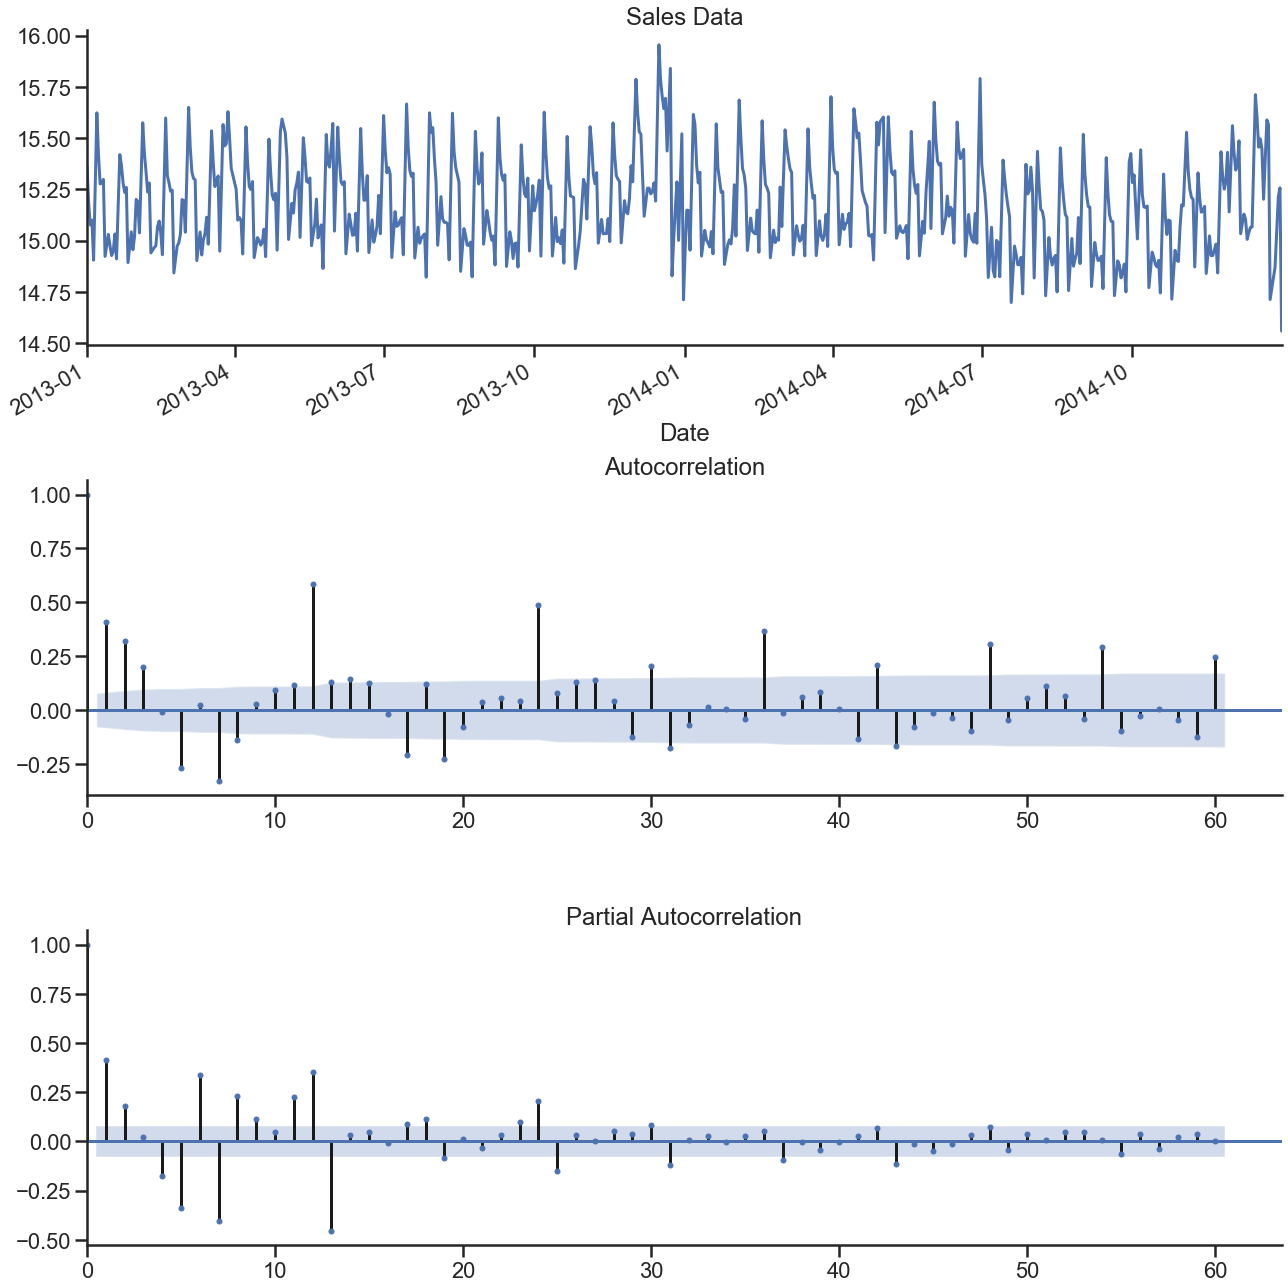

In [5]:
armf.tsplot(trainset_1.LogSales, lags=60,
            title='Sales Data', figsize=(18,18))

In [6]:
armf.adfuller_test(trainset_1.Sales, title='Sales')

The results for the Augmented Dickey-Fuller test for Sales:

Test Statistic             -4.172542
p-value                     0.000733
Number of Lags Used        18.000000
Number of Observations    607.000000
Critical Value (1%)        -3.441169
Critical Value (5%)        -2.866313
Critical Value (10%)       -2.569312
dtype: float64


From the augmented dickey-fuller tests, we can conclude that the series is stationary at the 1% significance level.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f487b07dd10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f486d65f8d0>)

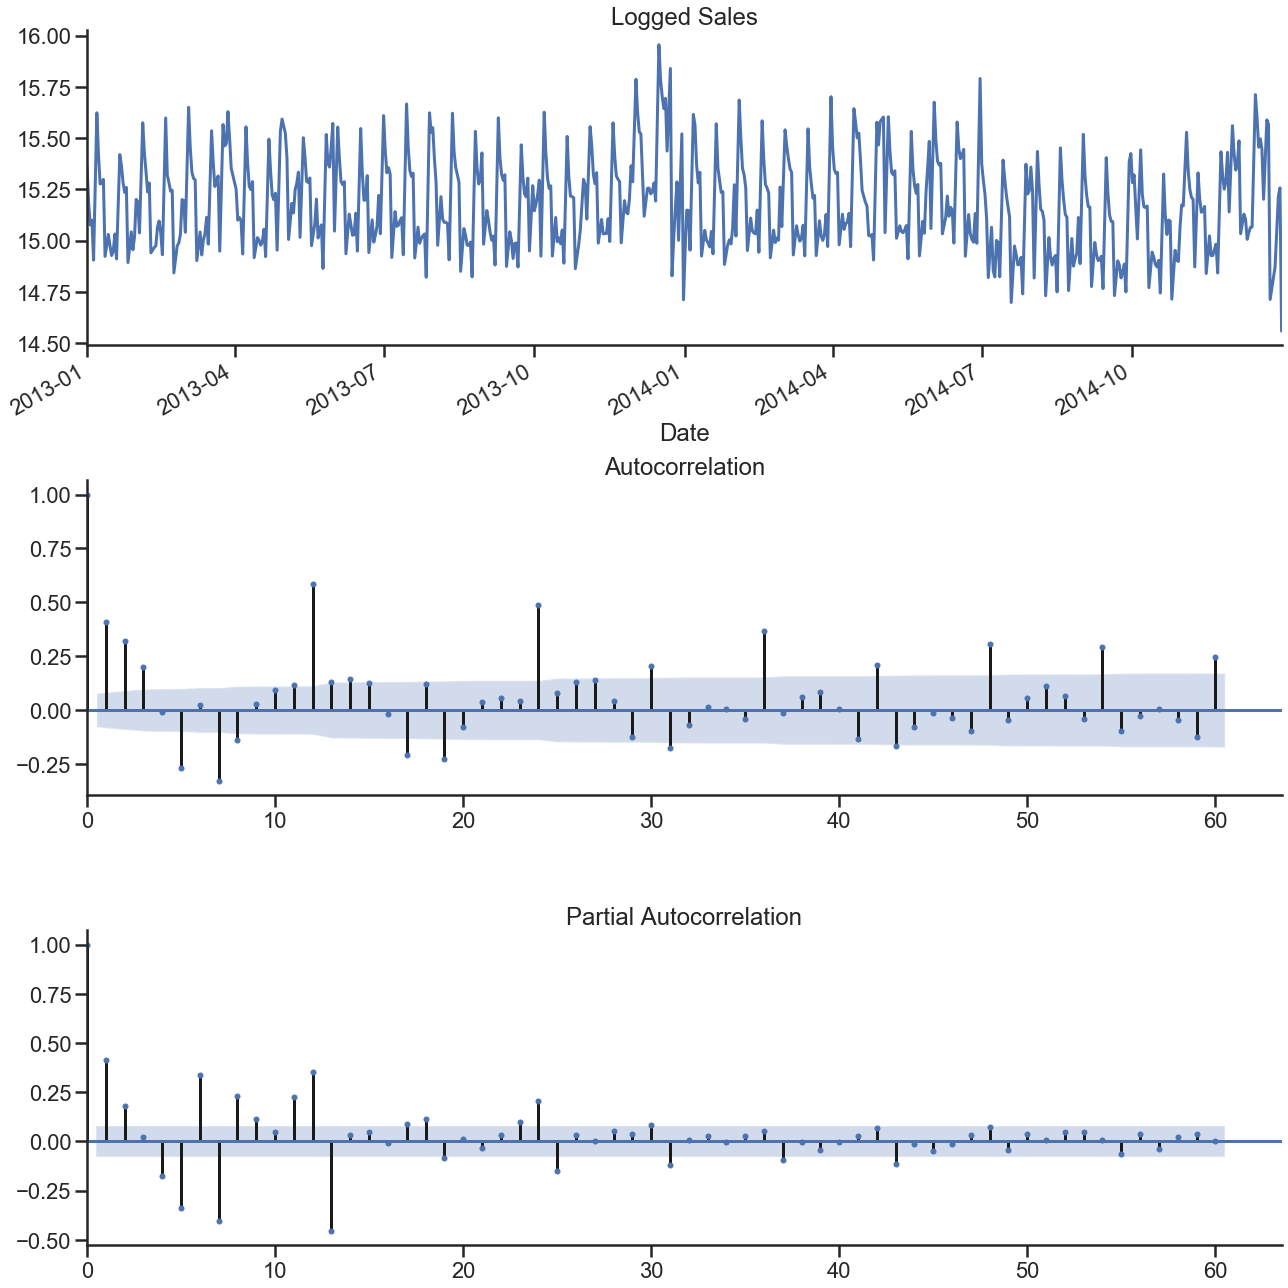

In [7]:
armf.tsplot(trainset_1.LogSales, lags=60,
            title='Logged Sales', figsize=(18,18))

In [8]:
armf.adfuller_test(trainset_1.LogSales, title='Logged Sales')

The results for the Augmented Dickey-Fuller test for Logged Sales:

Test Statistic             -4.171704
p-value                     0.000735
Number of Lags Used        18.000000
Number of Observations    607.000000
Critical Value (1%)        -3.441169
Critical Value (5%)        -2.866313
Critical Value (10%)       -2.569312
dtype: float64


From the above plots, both sales and logged sales are stationary. However, there seems to be some sort of bi-weekly seasonality.

We will next perform a grid search to find which model ARIMA model best fits the data. Next, we will inspect the significance of the coefficient and decide to proceed with the selected model from the grid search or make adjustments.

From our initial analysis using the Box-Jenkins approach, it appears that there are up to 12 significant Autoregressive and Moving Average terms. 

## Parameter Optimisation and Model Selection

#### ARIMA Model - Allowing up to 12 AR and MA terms each. No dummy variables. 

In [9]:
ARIMA_12_results = armf.optimise_SARIMAX(trainset_1.LogSales, exog=None,
                                         max_p=12, max_q=12, d=0)

Total number of parameter permutations is : 144
  Parameters         AIC
0   (12, 12) -819.522015
1   (10, 10) -808.914313
2   (12, 11) -808.731259
3    (12, 9) -805.527918
4   (11, 11) -805.255884
5    (11, 9) -801.892786
6   (11, 10) -801.301722
7   (12, 10) -800.884492
8    (11, 8) -800.048347
9    (12, 8) -797.537072


The optimal model from the grid search is an ARIMA(12,0,12). We will now examine the coefficients of the selected model.

In [10]:
ARIMA_12_model, ARIMA_12_order = armf.model_selection(ARIMA_12_results,
                                                      trainset_1.LogSales, 
                                                      exog=None)

                           Statespace Model Results                           
Dep. Variable:               LogSales   No. Observations:                  626
Model:             SARIMAX(12, 0, 12)   Log Likelihood                 434.761
Date:                Tue, 28 Jan 2020   AIC                           -819.522
Time:                        17:01:27   BIC                           -708.538
Sample:                             0   HQIC                          -776.401
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0610      0.107      0.569      0.569      -0.149       0.271
ar.L2         -0.1254      0.123     -1.021      0.307      -0.366       0.115
ar.L3          0.1679      0.111      1.519      0.1

Looking at the coefficients, we observe that most of the autoregressive terms are actually insignificant at the 10% level, besides the 6th and 12th coefficients which highlights the weekly seasonality present.

As for the moving average terms, most of them are significant at the 10% level, therefore we will now attempt another grid search, setting the SARIMA component at (2,0,0) and allowing up to 12 moving average terms.

In [9]:
SARIMA_results = armf.optimise_SARIMAX(endog=trainset_1.LogSales,
                                       min_p=0, max_p=0,
                                       min_q=1, max_q=12,
                                       min_P=0, max_P=2,
                                       min_Q=0, max_Q=0,
                                       seasonal=True, S=6, D=0)

Total number of parameter permutations is : 36
      Parameters         AIC
0  (0, 11, 2, 0) -811.586216
1  (0, 10, 2, 0) -784.503132
2   (0, 8, 2, 0) -775.613918
3   (0, 9, 2, 0) -773.258427
4   (0, 7, 2, 0) -761.797953
5   (0, 5, 2, 0) -760.794787
6   (0, 6, 2, 0) -759.623153
7   (0, 4, 2, 0) -698.278814
8   (0, 3, 2, 0) -662.508042
9   (0, 2, 2, 0) -655.301127


The SARIMA (2,0,0) x (0,0,11) was selected as the optimal model. We will now check the model coefficients again.

In [13]:
SARIMA_model, SARIMA_order, SARIMA_seasonal_order = armf.model_selection(SARIMA_results,
                                                                         trainset_1.LogSales,
                                                                         exog=None,
                                                                         seasonal=True, S=6)

                                 Statespace Model Results                                 
Dep. Variable:                           LogSales   No. Observations:                  626
Model:             SARIMAX(0, 0, 11)x(2, 0, 0, 6)   Log Likelihood                 419.793
Date:                            Wed, 29 Jan 2020   AIC                           -811.586
Time:                                    12:58:15   BIC                           -749.435
Sample:                                         0   HQIC                          -787.438
                                            - 626                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8978      0.038     23.653      0.000       0.823       0.972
ma.L2          0.7905      0.051   

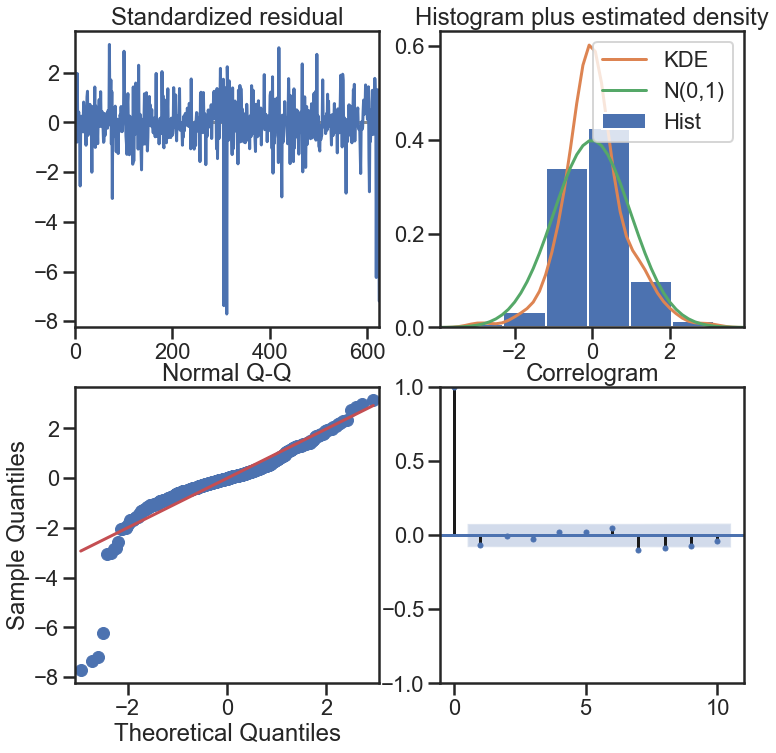

In [16]:
SARIMA_diagnostics = SARIMA_model.plot_diagnostics(figsize=(12,12))

While the Jarque Bera and Ljung Box tests for normality of residuals indicated non-normality of our model residuals, however, looking at the diagnostic plots, the distribution looks approximately normal, and the deviations are caused by large negative errors due to days with stores closing and thus having 0 Sales.

Therefore, we believe the model coefficients to still be reliable and our final model chosen for will be a SARIMA (2,0,0,6) x (0,0,11) model.

#### Checking Model for overfitting

In [17]:
SARIMA_prediction, SARIMA_MAPE, SARIMA_RMSE = armf.SARIMAX_forecast(trainset_1,
                                                                    testset_1,
                                                                    'LogSales',
                                                                    SARIMA_order,
                                                                    SARIMA_seasonal_order)

The Mean Absolute Percentage Error is: 25028.20%.
The Root Mean Squared Error is: 31302.96.


It appears we have have an anomalous data point that is messing up our results.

In [25]:
SARIMA_prediction.describe()

,LogSales,Forecasts
count,77.000000,77.000000
mean,15.202908,3786.660943
std,0.198594,31278.685555
min,14.832951,14.755292
25%,15.034546,15.069514
50%,15.196508,15.230042
75%,15.323798,15.310097
max,15.689421,274219.357979


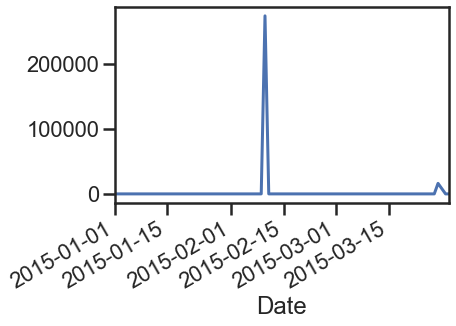

In [27]:
SARIMA_prediction.Forecasts.plot()

In [29]:
SARIMA_prediction.loc[SARIMA_prediction.Forecasts > 20]

,LogSales,Forecasts
Date,,
2015-02-10,15.071898,274219.357979
2015-03-28,15.023373,16213.666864


Let's remove these two points and see our results again.

In [30]:
SARIMA_prediction_new = SARIMA_prediction.loc[SARIMA_prediction.Forecasts < 20]

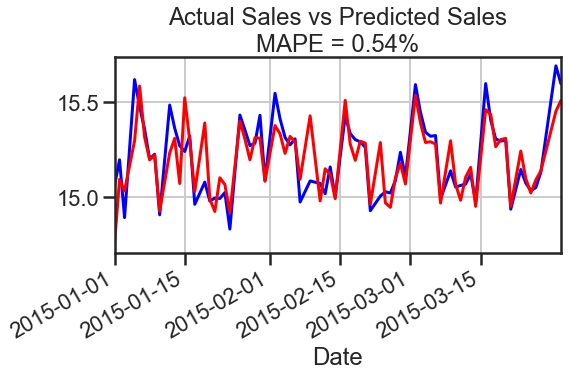

In [32]:
armf.predictions_plot(SARIMA_prediction_new.LogSales, SARIMA_prediction_new.Forecasts)

After removing the anomalous forecasts, we can see that our model is able to predict the next day's sales quite accurately and follows the trend well.

We will now check the model again using a second train and tesing dataset.

In [33]:
SARIMA_prediction, SARIMA_MAPE, SARIMA_RMSE = armf.SARIMAX_forecast(trainset_2,
                                                                    testset_2,
                                                                    'LogSales',
                                                                    SARIMA_order,
                                                                    SARIMA_seasonal_order)

The Mean Absolute Percentage Error is: 48807448666.98%.
The Root Mean Squared Error is: 74963886746.94.


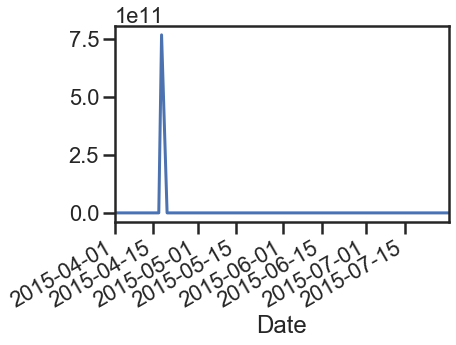

In [41]:
SARIMA_prediction.Forecasts.plot()

In [37]:
# Checking for anomalies
SARIMA_prediction.loc[SARIMA_prediction.Forecasts > 20]

,LogSales,Forecasts
Date,,
2015-04-18,14.988954,7.681513e+11


In [39]:
SARIMA_prediction_new = SARIMA_prediction.loc[SARIMA_prediction.Forecasts < 20]

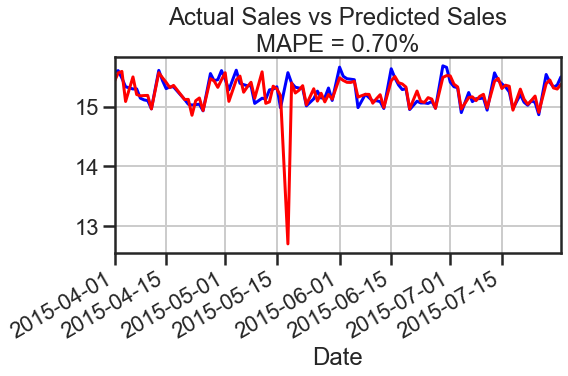

In [40]:
armf.predictions_plot(SARIMA_prediction_new.LogSales, SARIMA_prediction_new.Forecasts)

In [42]:
SARIMA_prediction_new = SARIMA_prediction_new.loc[SARIMA_prediction.Forecasts > 14]

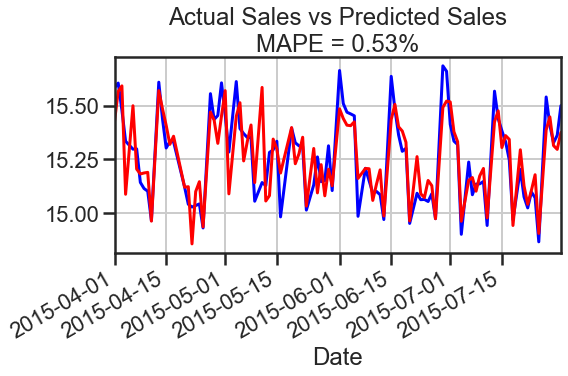

In [43]:
armf.predictions_plot(SARIMA_prediction_new.LogSales, SARIMA_prediction_new.Forecasts)

Removing anomalous forecasts, we can see that the model is able to accurately predict the next day's sales. 

Next, we will compare the performance between this model and boosting algorithms.